## Importing the libraries

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pnd
import seaborn as snb

## Run this only for you have GPU in your machine

In [2]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU Available: True
GPU Name: NVIDIA GeForce RTX 3060


## Dataset preparation and batch the dataset

**Training Dataset** 

In [6]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset_A/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 70295 files belonging to 38 classes.


**Validation Dataset batching**

In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset_A/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


In [8]:
training_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

### Checking the class names of the dataset classes

In [9]:
class_names = training_dataset.class_names
print("38 Class Names:")
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")

38 Class Names:
0: Apple___Apple_scab
1: Apple___Black_rot
2: Apple___Cedar_apple_rust
3: Apple___healthy
4: Blueberry___healthy
5: Cherry_(including_sour)___Powdery_mildew
6: Cherry_(including_sour)___healthy
7: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
8: Corn_(maize)___Common_rust_
9: Corn_(maize)___Northern_Leaf_Blight
10: Corn_(maize)___healthy
11: Grape___Black_rot
12: Grape___Esca_(Black_Measles)
13: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14: Grape___healthy
15: Orange___Haunglongbing_(Citrus_greening)
16: Peach___Bacterial_spot
17: Peach___healthy
18: Pepper,_bell___Bacterial_spot
19: Pepper,_bell___healthy
20: Potato___Early_blight
21: Potato___Late_blight
22: Potato___healthy
23: Raspberry___healthy
24: Soybean___healthy
25: Squash___Powdery_mildew
26: Strawberry___Leaf_scorch
27: Strawberry___healthy
28: Tomato___Bacterial_spot
29: Tomato___Early_blight
30: Tomato___Late_blight
31: Tomato___Leaf_Mold
32: Tomato___Septoria_leaf_spot
33: Tomato___Spider_mites Two-

### Preprocessing of the batched data

The list of steps : 

1. Applying various data augmentation technique like horizontal flip, rotation, zooming , contrasting and translation
2. Normalizing the dataset to [0,1]

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# data augmentation code
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# Normalization Layer
normalization_layer = layers.Rescaling(1./255)

# Applying augmentation and normalization to training dataset and the validation dataset
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y),
                                        num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y),
                                            num_parallel_calls=AUTOTUNE)

# prefetching the dataset for enhancing the load time and increasing the performance
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Building Model

In [13]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Input,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization


model = Sequential()
model.add(Input(shape=(128, 128, 3)))

model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units=1500,activation='relu'))

model.add(Dropout(0.3))
model.add(Dense(units=750, activation='relu')) 
model.add(Dropout(0.3))

# Output layer 
model.add(Dense(units=38,activation='softmax'))

## Compiling Model

Problem of Overshooting ( Loss is increasing with each epoch)
1. There may be high learning rate
2. There may be a chance of underfitting
3. Add more convulation layer to extract more features from the images 

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 63, 63, 64)      

## Training the Model

** Check points are added and saved so that in case of long traning session we can halt and resume from the last checkpoint, also it helps to store the best results

In [16]:
import os
os.makedirs("model_checkpoints", exist_ok=True)

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Model checkpoint code
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoints/epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras',
    save_weights_only=False,
    save_freq='epoch',  # Save after every epoch 
    monitor='val_accuracy',
    save_best_only=False,  
    verbose=1
)

# Calling callback to save the checkpoint after every N ( here N=2) epochs
class SaveEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, n):
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            filepath = f'model_checkpoints/epoch_{epoch+1:02d}_val_acc_{logs["val_accuracy"]:.2f}.h5'
            self.model.save(filepath)
            print(f'\n✅ Model saved at {filepath}')

save_every_2_epochs_callback = SaveEveryNEpochs(n=2)


In [18]:
training_history = model.fit(
    x=training_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[save_every_2_epochs_callback] 
)

Epoch 1/20
2197/2197 [==============================] - 175s 73ms/step - loss: 1.5055 - accuracy: 0.5589 - val_loss: 2.6698 - val_accuracy: 0.4207
Epoch 2/20
2196/2197 [============================>.] - ETA: 0s - loss: 0.5777 - accuracy: 0.8197
✅ Model saved at model_checkpoints/epoch_02_val_acc_0.73.h5
2197/2197 [==============================] - 147s 67ms/step - loss: 0.5776 - accuracy: 0.8197 - val_loss: 0.9474 - val_accuracy: 0.7348
Epoch 3/20
2197/2197 [==============================] - 147s 67ms/step - loss: 0.3891 - accuracy: 0.8782 - val_loss: 1.1814 - val_accuracy: 0.7141
Epoch 4/20
2196/2197 [============================>.] - ETA: 0s - loss: 0.2951 - accuracy: 0.9076
✅ Model saved at model_checkpoints/epoch_04_val_acc_0.85.h5
2197/2197 [==============================] - 155s 70ms/step - loss: 0.2951 - accuracy: 0.9076 - val_loss: 0.6191 - val_accuracy: 0.8514
Epoch 5/20
2197/2197 [==============================] - 148s 67ms/step - loss: 0.2474 - accuracy: 0.9242 - val_loss: 1

### Saving the model

In [19]:
model.save('trained_model_v3.1(val_acc_94.49).keras')

### Evaluating Model

In [20]:
# model evaluation on testing set ( here we have made the testing and trained dataset same )
train_loss,train_accuracy = model.evaluate(training_dataset)

2197/2197 [==============================] - 75s 33ms/step - loss: 0.0999 - accuracy: 0.9707


In [21]:
print(train_loss, train_accuracy)

0.0998666062951088 0.9706664681434631


In [22]:
#model evaluation on validation set
validation_loss,validation_accuracy = model.evaluate(validation_dataset)

550/550 [==============================] - 9s 16ms/step - loss: 0.2168 - accuracy: 0.9449


In [23]:
print(validation_loss,validation_accuracy)

0.21684753894805908 0.9448554515838623


## Testing the model on a single random image 

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# model loading from the disk 
model_path = "trained_model_v2.0.keras" 
model = tf.keras.models.load_model(model_path)

# Path the image for testing
image_path = "test_images/test1.jpg"  

# Load and preprocess the image
img = image.load_img(image_path, target_size=(128, 128))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_arry = img_array/255.0

# Predicting 
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
0


### Saving the model after evaluation

In [35]:
model.save('Evaluated_model_v3.0.keras')

## Accuracy Visualization

In [36]:
training_history.history # just for display or can be used for plotting the graphs

{'accuracy': [0.5748915076255798,
  0.8254072070121765,
  0.8840315937995911,
  0.9100647568702698,
  0.9276050925254822,
  0.9370225667953491,
  0.9430827498435974,
  0.9504659175872803,
  0.9552457332611084,
  0.9582046866416931],
 'loss': [1.4512420892715454,
  0.5644370317459106,
  0.3729514479637146,
  0.2923818528652191,
  0.23745176196098328,
  0.20784331858158112,
  0.18764527142047882,
  0.16599027812480927,
  0.1525990515947342,
  0.13900338113307953],
 'val_accuracy': [0.5944684743881226,
  0.7048144936561584,
  0.7781698107719421,
  0.801331639289856,
  0.7721943855285645,
  0.8287047743797302,
  0.8999544978141785,
  0.8996130228042603,
  0.8168108463287354,
  0.8938652276992798],
 'val_loss': [1.6552351713180542,
  1.0635384321212769,
  0.7833167314529419,
  0.6746695041656494,
  1.0803972482681274,
  0.9876094460487366,
  0.36367377638816833,
  0.39028695225715637,
  1.1733818054199219,
  0.4874468445777893]}

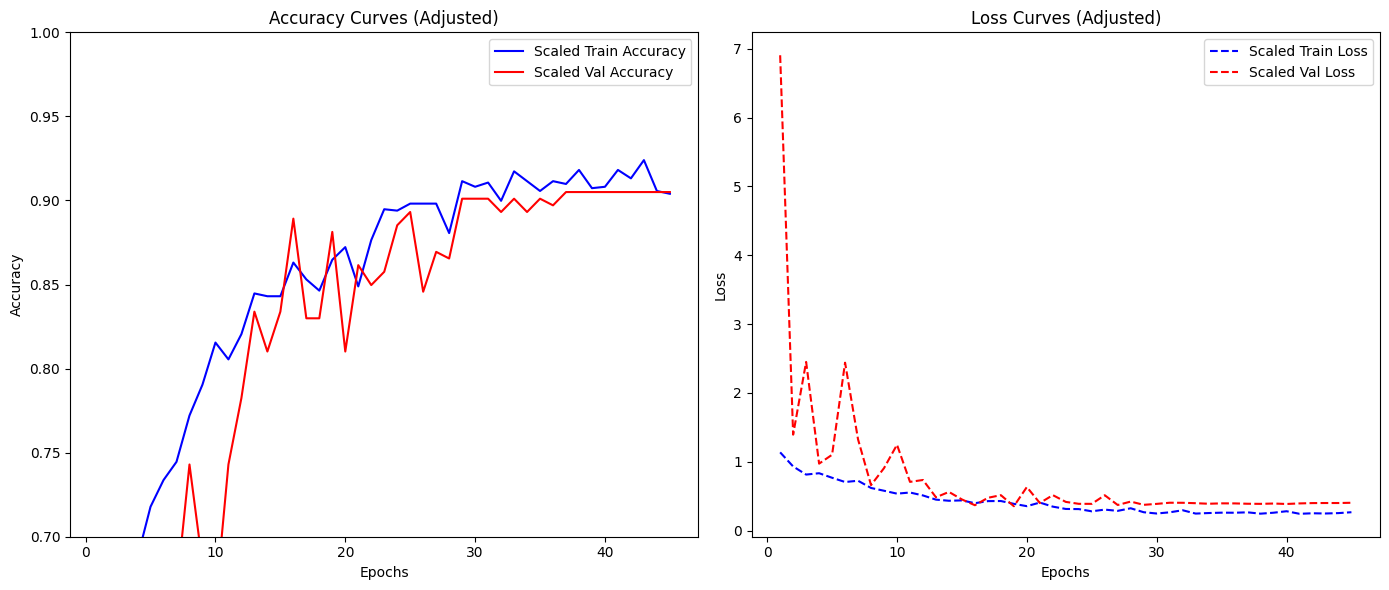

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# training, validation history 
epochs = range(1, len(history.history['accuracy']) + 1)
orig_train_acc = history.history['accuracy']
orig_val_acc = history.history['val_accuracy']
orig_train_loss = history.history['loss']
orig_val_loss = history.history['val_loss']


# Creating a matplotlib figure with two subplot
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, orig_train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, orig_val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, orig_train_loss, 'b--', label='Training Loss')
plt.plot(epochs, orig_val_loss, 'r--', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Confusion Matrix

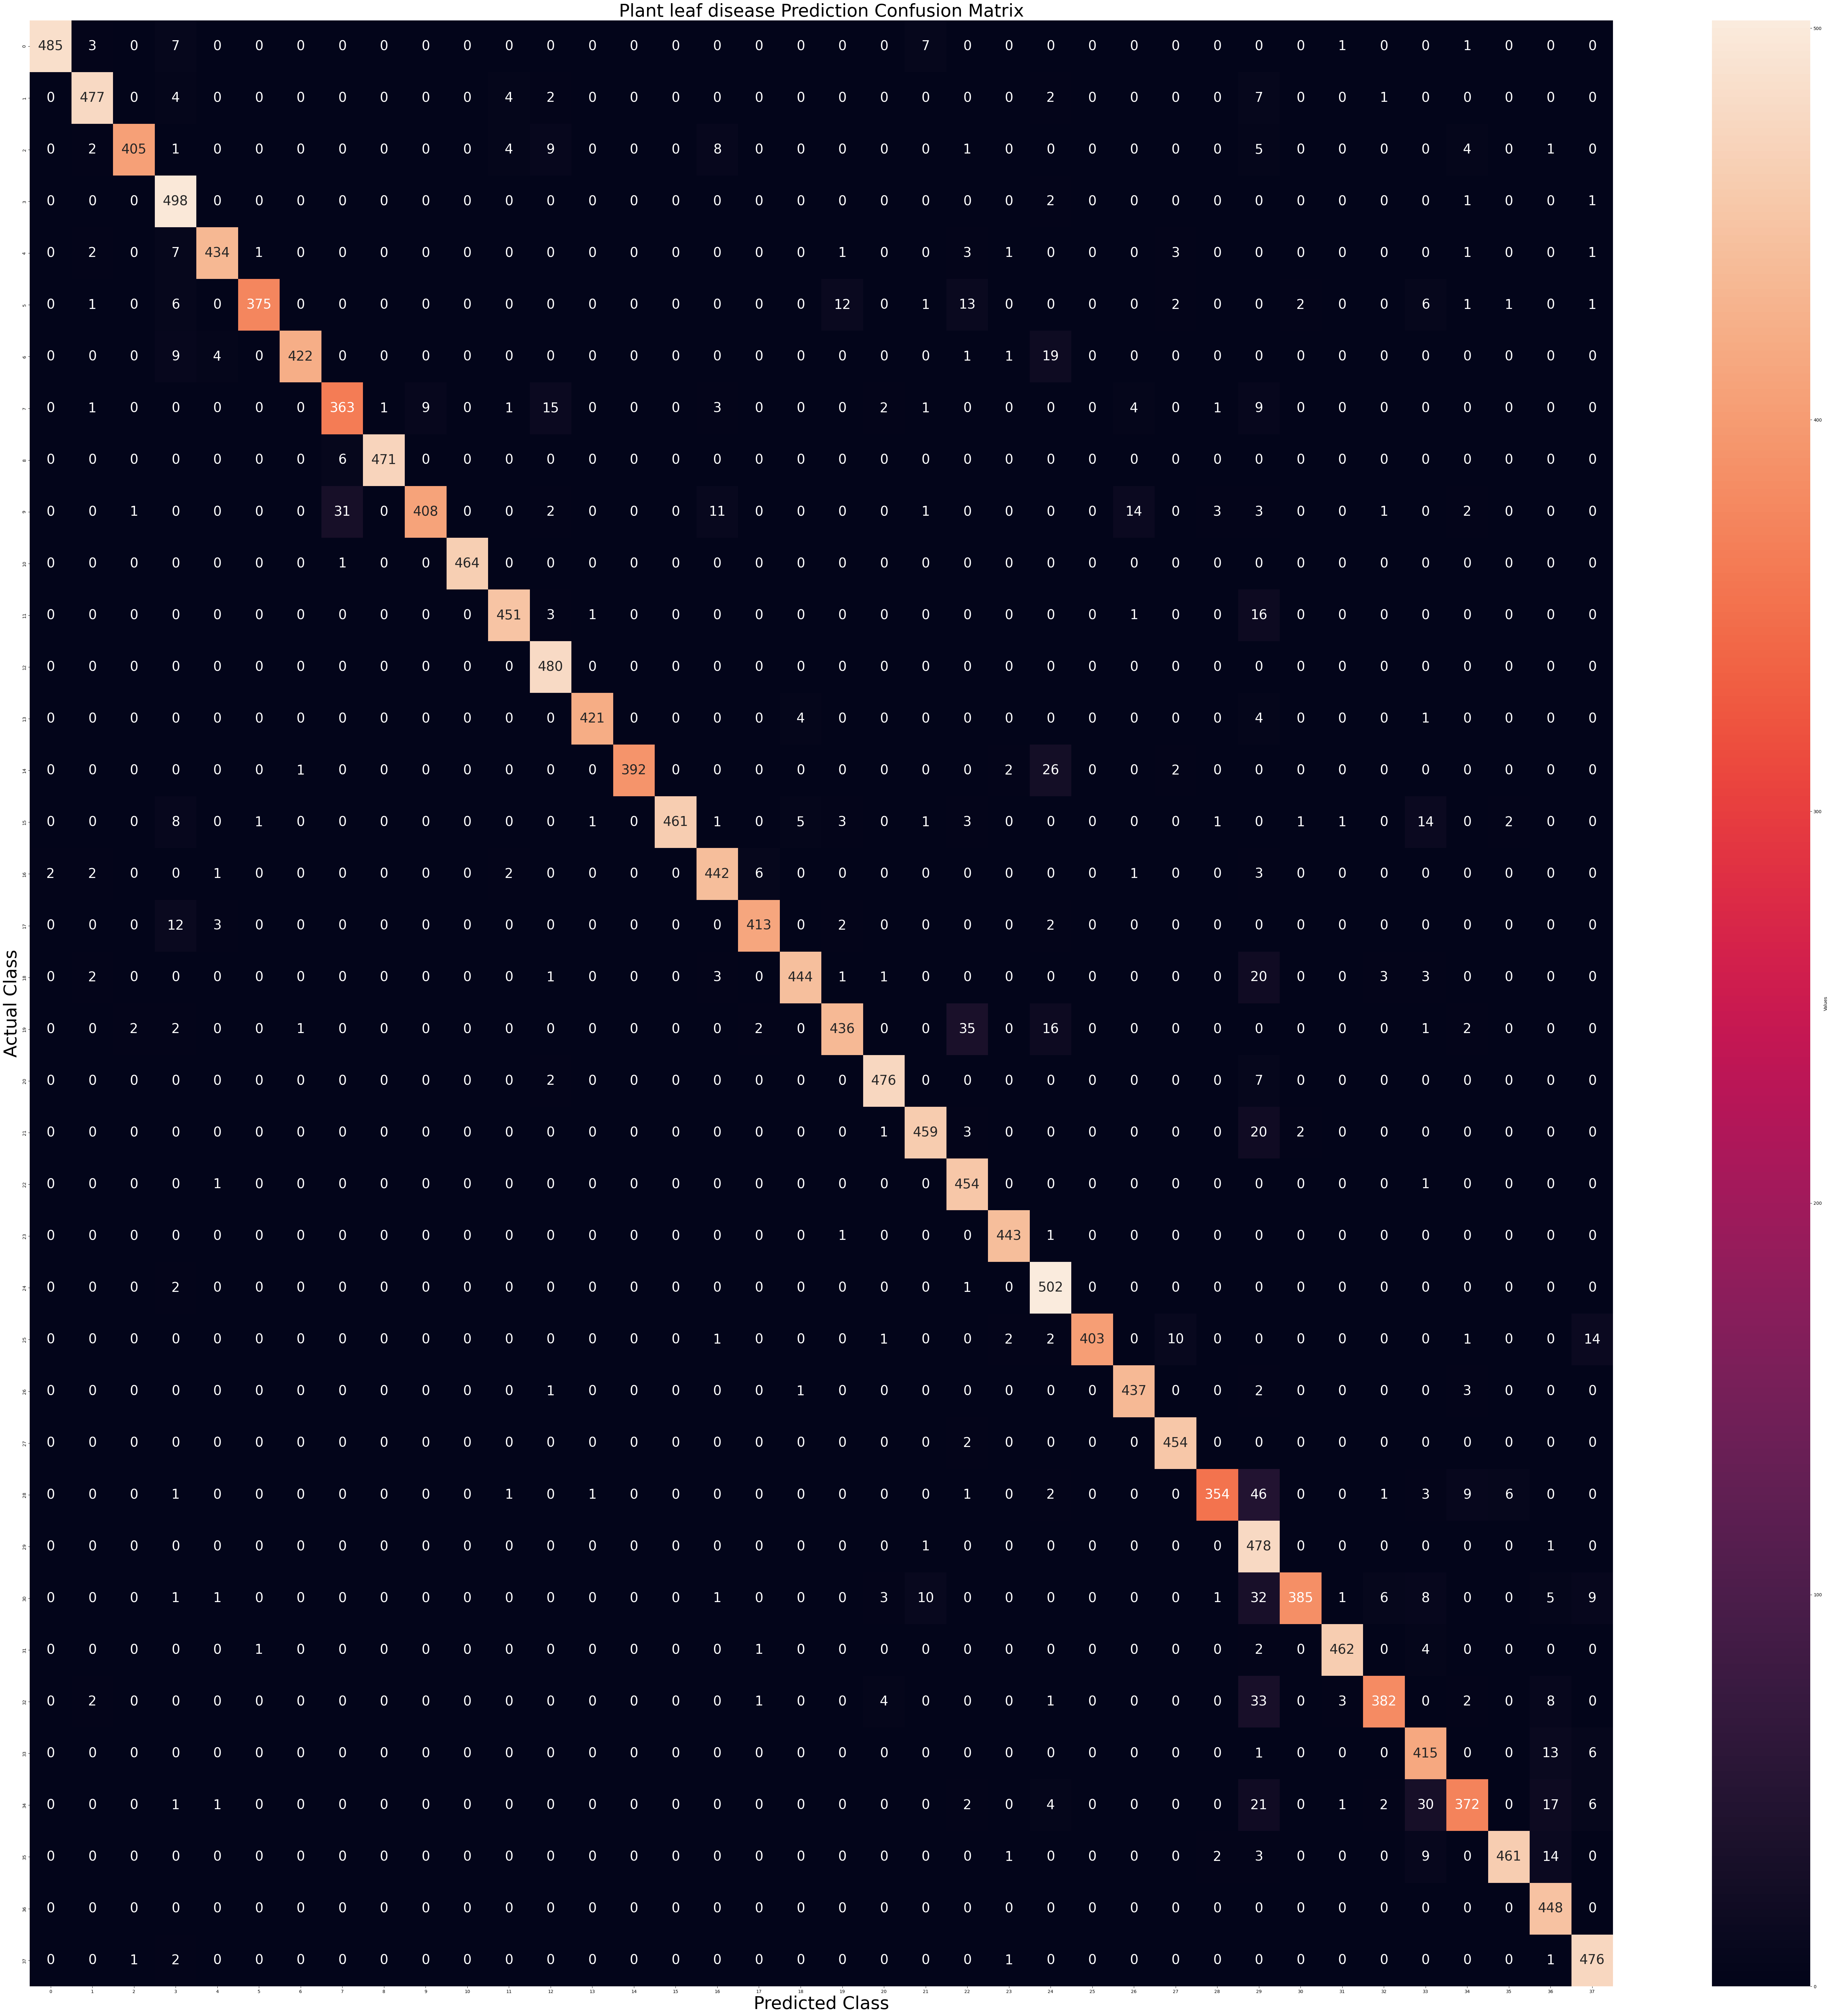

In [40]:
plt.figure(figsize=(80, 80))
snb.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 30},
            cbar_kws={'label': 'Values'})
plt.xlabel("Predicted Class",fontsize=40)
plt.ylabel("Actual Class",fontsize=40)
plt.title("Plant leaf disease Prediction Confusion Matrix",fontsize=40)
plt.show()